In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import contextily as cx

Totale deformatie, gemiddeld over y en z. Snelheid gemiddeld per maand, gemiddeld over y en z.
Kansscore deformatie kade:
Deformatie y/z < 15 (mm), snelheid y/z <5 (mm/maand), kansscore 1 (groen)\
Deformatie y/z 15-25 (mm), snelheid y/z 5-10 (mm/maand), kansscore 2 (geel)\
Deformatie y/z 25-35 (mm), snelheid y/z 10-15 (mm/maand), kansscore 3 (oranje)\
Deformatie y/z > 35 (mm), snelheid y/z >15 (mm/maand), kansscore 4 (rood)


In [38]:
cpt = pd.read_csv('../Data/CPT_train_v2.csv', index_col=0)
objects = cpt.index

In [39]:
objects

Index(['BDG0101', 'BDG0202', 'DCG0101', 'DCG0202', 'DCG0302', 'GRW0101',
       'HEG0302', 'HEG0401', 'HEG0802', 'HEG0901', 'KVV0602', 'KVV0702',
       'KZG0301', 'KZG0302', 'LLG0102', 'LLG0202', 'LYG0501', 'LYG0601',
       'NHG0201', 'OVW0601', 'PRG0301', 'PRG0401', 'PRG0402', 'SIN0501',
       'SIN0502', 'SIN0601', 'SIN0602', 'SIN0701', 'WEG0201', 'WKN0101'],
      dtype='object')

In [40]:
Y_y = pd.read_csv('../Data/TargetY.csv', index_col=0)

In [42]:
Y_z = pd.read_csv('../Data/TargetZ.csv', index_col=0)

In [43]:
def_total_z = Y_z.iloc[:,4:].mean(axis=1)

In [44]:
Y_y.iloc[-1][Y_y.iloc[-1].last_valid_index()]

1.299999999901047

In [45]:
def_total_y = Y_y.iloc[:, 4:].apply(lambda x: x.loc[x.last_valid_index()], axis=1)
def_total_z = Y_z.iloc[:, 4:].apply(lambda x: x.loc[x.last_valid_index()], axis=1)

In [46]:
def_speed_y = Y_y.iloc[:,4:].diff(axis=1).mean(axis=1)
def_speed_z = Y_z.iloc[:,4:].diff(axis=1).mean(axis=1)

In [47]:
def_speed_z.min()

-0.45135135135481236

In [48]:
df_agg_values = pd.DataFrame({'total_y':def_total_y, 'total_z':def_total_z, 'speed_y':def_speed_y, 'speed_z':def_speed_z})

In [49]:
df_agg_values['X_coordinate'] = Y_y['X_coordinate']
df_agg_values['Y_coordinate'] = Y_y['Y_coordinate']

In [50]:
df_agg_values['RiskScore'] = 1

In [51]:
medium_risk = df_agg_values[(df_agg_values['total_y'].abs() >= 15) | (df_agg_values['total_z'].abs() >= 15) | \
             (df_agg_values['speed_y'].abs() >= 5) | (df_agg_values['speed_z'].abs() >= 5)].index
high_risk = df_agg_values[(df_agg_values['total_y'].abs() >= 25) | (df_agg_values['total_z'].abs() >= 25) | \
             (df_agg_values['speed_y'].abs() >= 10) | (df_agg_values['speed_z'].abs() >= 10)].index
acute_risk = df_agg_values[(df_agg_values['total_y'].abs() > 35) | (df_agg_values['total_z'].abs() > 35) | \
             (df_agg_values['speed_y'].abs() > 15) | (df_agg_values['speed_z'].abs() > 15)].index

In [52]:
df_agg_values.loc[medium_risk, 'RiskScore'] = 2
df_agg_values.loc[high_risk, 'RiskScore'] = 3
df_agg_values.loc[acute_risk, 'RiskScore'] = 4

Deformatie y/z < 15 (mm), snelheid y/z <5 (mm/maand), kansscore 1 (groen)\
Deformatie y/z 15-25 (mm), snelheid y/z 5-10 (mm/maand), kansscore 2 (geel)\
Deformatie y/z 25-35 (mm), snelheid y/z 10-15 (mm/maand), kansscore 3 (oranje)\
Deformatie y/z > 35 (mm), snelheid y/z >15 (mm/maand), kansscore 4 (rood)

In [53]:
df_agg_values['RiskScore'].unique()

array([1, 2, 3, 4], dtype=int64)

In [55]:
df_agg_values = df_agg_values[df_agg_values['X_coordinate'] > 100000]

In [56]:
train_agg_values = pd.read_csv('../Data/ARK_risk_scores.csv', index_col=0) 
df_agg_values = df_agg_values[df_agg_values.index.isin(train_agg_values.index)]

In [57]:
df_agg_values['points'] = gpd.points_from_xy(df_agg_values['X_coordinate'], df_agg_values['Y_coordinate'])
gdf_agg = gpd.GeoDataFrame(df_agg_values, crs="EPSG:28992", geometry=df_agg_values['points'])
gdf_agg = gdf_agg.to_crs("EPSG: 4326")

In [58]:
gdf_agg['RiskScore'].unique()

array([1, 2, 3], dtype=int64)

C:\Users\julia\anaconda3\lib\site-packages\geopandas\plotting.py:693: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(


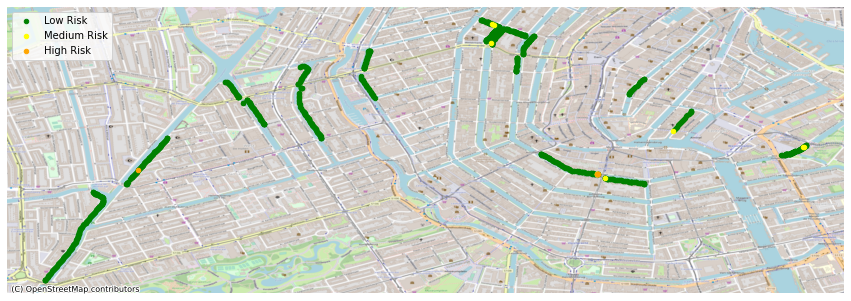

In [59]:
fig, ax = plt.subplots(figsize=(15,15))

gdf_agg[gdf_agg['RiskScore'] == 1].plot(ax=ax, color='g', markersize=20, label='Low Risk')
gdf_agg[gdf_agg['RiskScore'] == 2].plot(ax=ax, color='yellow', markersize=20, label='Medium Risk')
gdf_agg[gdf_agg['RiskScore'] == 3].plot(ax=ax, color='orange', markersize=20, label='High Risk')
gdf_agg[gdf_agg['RiskScore'] == 4].plot(ax=ax, color='r', markersize=20, label='Acute Risk')

cx.add_basemap(ax=ax, source=cx.providers.OpenStreetMap.Mapnik, crs=gdf_agg.crs)
plt.legend(loc='upper left')
ax.axis('off')
plt.show()